In [18]:
import numpy as np
import os
import random
import scipy
from scipy import signal
from numpy.fft import fft
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import he_normal

from sklearn.model_selection import train_test_split

import pandas as pd
import pickle

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [19]:
channels = ["Cz","Fz","Fp1","F7","F3","FC1","C3","FC5","FT9","T7","TP9","CP5","CP1","P3","P7","O1","Pz","O2","P8","P4","CP2","CP6",
            "TP10","T8","FT10","FC6","FC4","C4","FC2","F4","F8","Fp2"]

In [20]:
Fs = 128
# firフィルタを適用する
def firFilter(x):
    # fir filter
    b = signal.firwin(Fs * 2 - 1, [1.5/(Fs/2), 10.0/(Fs/2)], pass_zero=False)
    x[:, :-1] = signal.filtfilt(b, 1, x[:, :-1], axis=0)
    return x

In [21]:
# triggerからNポイント抽出する
N = 128
def triggerExtract(x, trigger):
    triggers = np.where(x[:, -1] == trigger)[0]
    print(len(triggers))
    if trigger == -1:
        triggers = triggers[:-2]
        result = np.zeros((len(triggers), 128, x.shape[1]))
    else:
        result = np.zeros((len(triggers), 128, x.shape[1]))
    i = 0
    for tmp in triggers:
        result[i] = x[tmp:tmp+N].reshape([1, -1, x.shape[1]])
        i += 1
    return result

In [22]:
# 波形の加算平均をとる
def WaveAverage(x):
    result = np.zeros((x.shape[1], x.shape[2]))
    for i in range(x.shape[0]):
        result += x[i]
    result = result / x.shape[0]
    return result

In [23]:
# 時間周波数解析
def time_frequency_spectrum(x):
    nfft = 96
    f, t, x = scipy.signal.spectrogram(x, fs=32, nfft=nfft, nperseg=nfft, noverlap=nfft-8, axis=1)
    return f, t, x

In [24]:
# N個の加算平均を取る
# def WaveAverageN(x, n):
#     result = np.zeros((int(x.shape[0]//n), x.shape[1], x.shape[2]))
#     for i in range(result):
#         tmp = np.zeros((1, x.shape[1], x.shape[2]))
#         for j in range(n):
#             tmp += x[]
#     return result

In [25]:
L39 = pickle.load(open("L39.binaryfile", 'rb'))
A = pickle.load(open("A.binaryfile", 'rb'))
P = pickle.load(open("P.binaryfile", 'rb'))
L39.shape, A.shape, P.shape

((13537, 33), (13537, 33), (13598, 33))

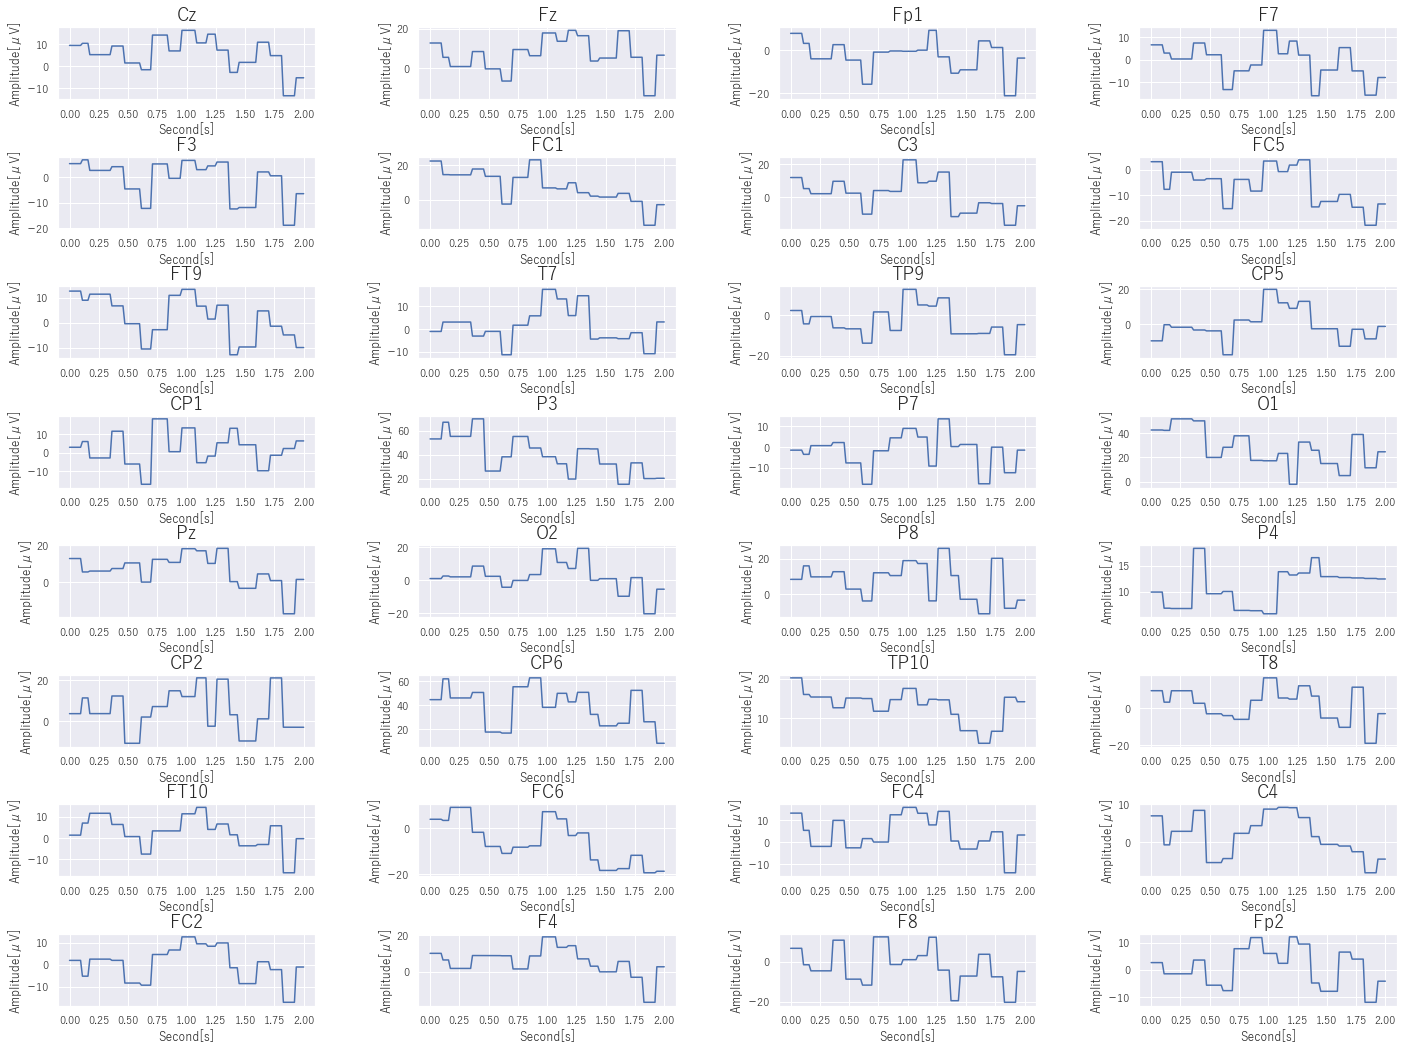

In [36]:
tt = np.linspace(0, 2, L39[128:256, 0].shape[0])
channel = 15
plt.figure(figsize=(24, 18))
plt.subplots_adjust(wspace=0.4, hspace=0.8)
for i in range(len(channels)):
    plt.subplot(8, 4, i+1)
    plt.plot(tt, L39[128:256, i])
    plt.xlabel("Second[s]")
    plt.ylabel("Amplitude[μV]")
    plt.xticks(np.arange(0, 2.25, 0.25))
    plt.title(channels[i], fontsize=18)

In [10]:
L39 = firFilter(L39)

In [11]:
L39_target = triggerExtract(L39, 1)
L39_nontarget = triggerExtract(L39, -1)
L39_target.shape, L39_nontarget.shape

39
181


((39, 128, 33), (179, 128, 33))

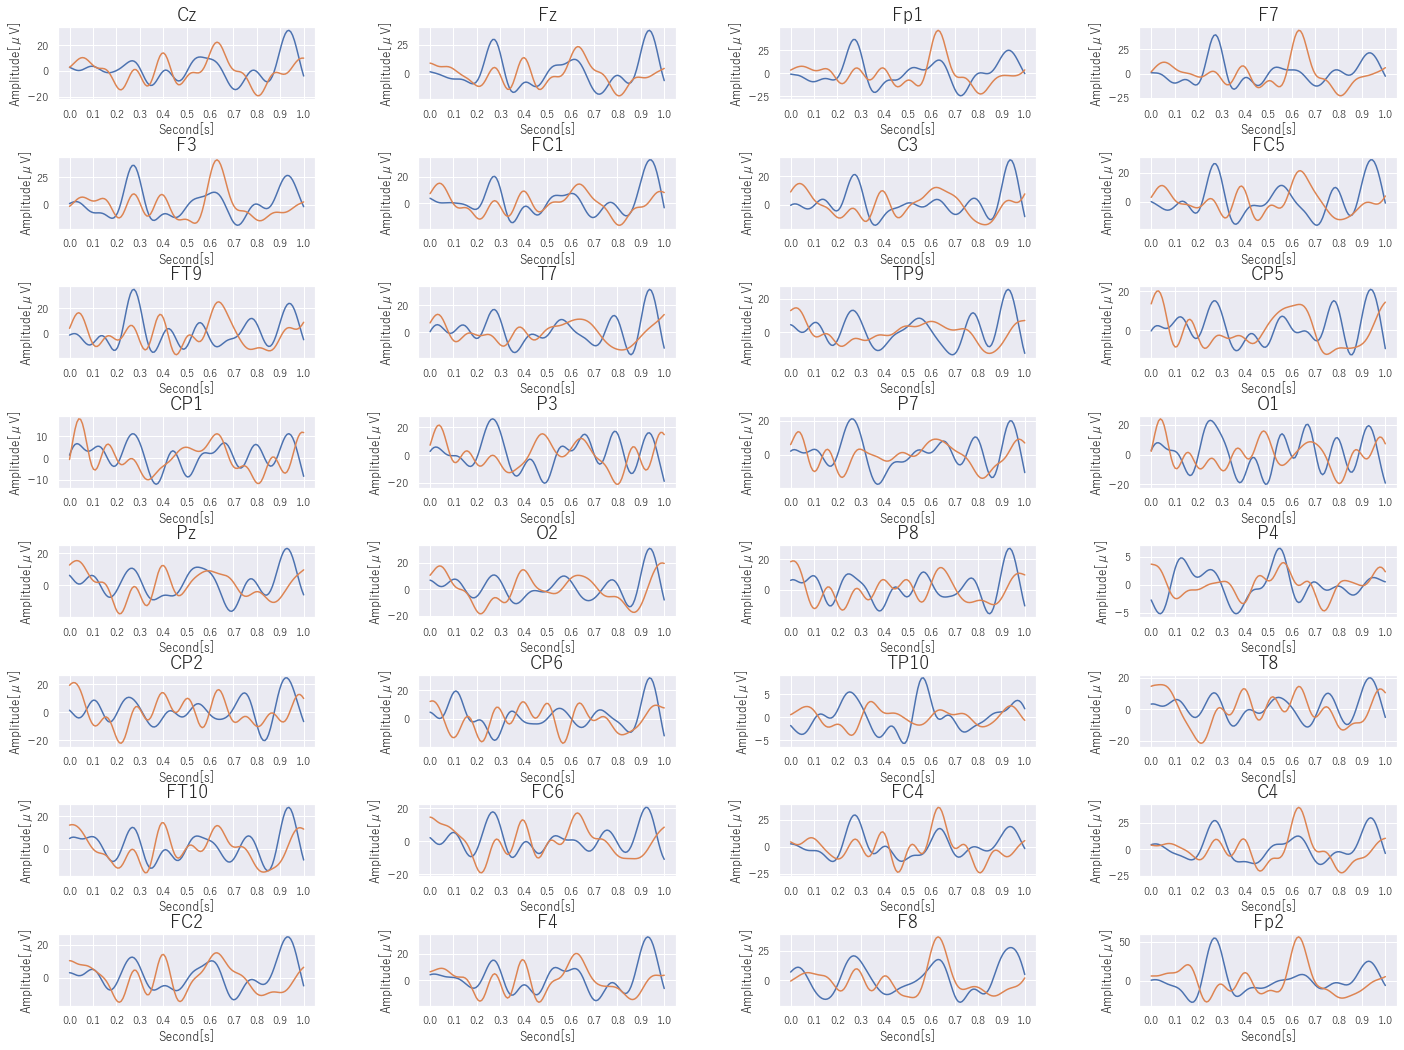

In [12]:
tt = np.linspace(0, 1, L39_target.shape[1])

plt.figure(figsize=(24, 18))
plt.subplots_adjust(wspace=0.4, hspace=0.8)
for i in range(len(channels)):
    plt.subplot(8, 4, i+1)
    plt.plot(tt, L39_target[5, :, i], label='target')
    plt.plot(tt, L39_nontarget[5, :, i], label='nontarget')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Second[s]")
    plt.ylabel("Amplitude[μV]")
    plt.title(channels[i], fontsize=18)
#     plt.legend()

In [13]:
L39_target_ave = WaveAverage(L39_target)
L39_nontarget_ave = WaveAverage(L39_nontarget)

L39_target_ave.shape, L39_nontarget_ave.shape

((128, 33), (128, 33))

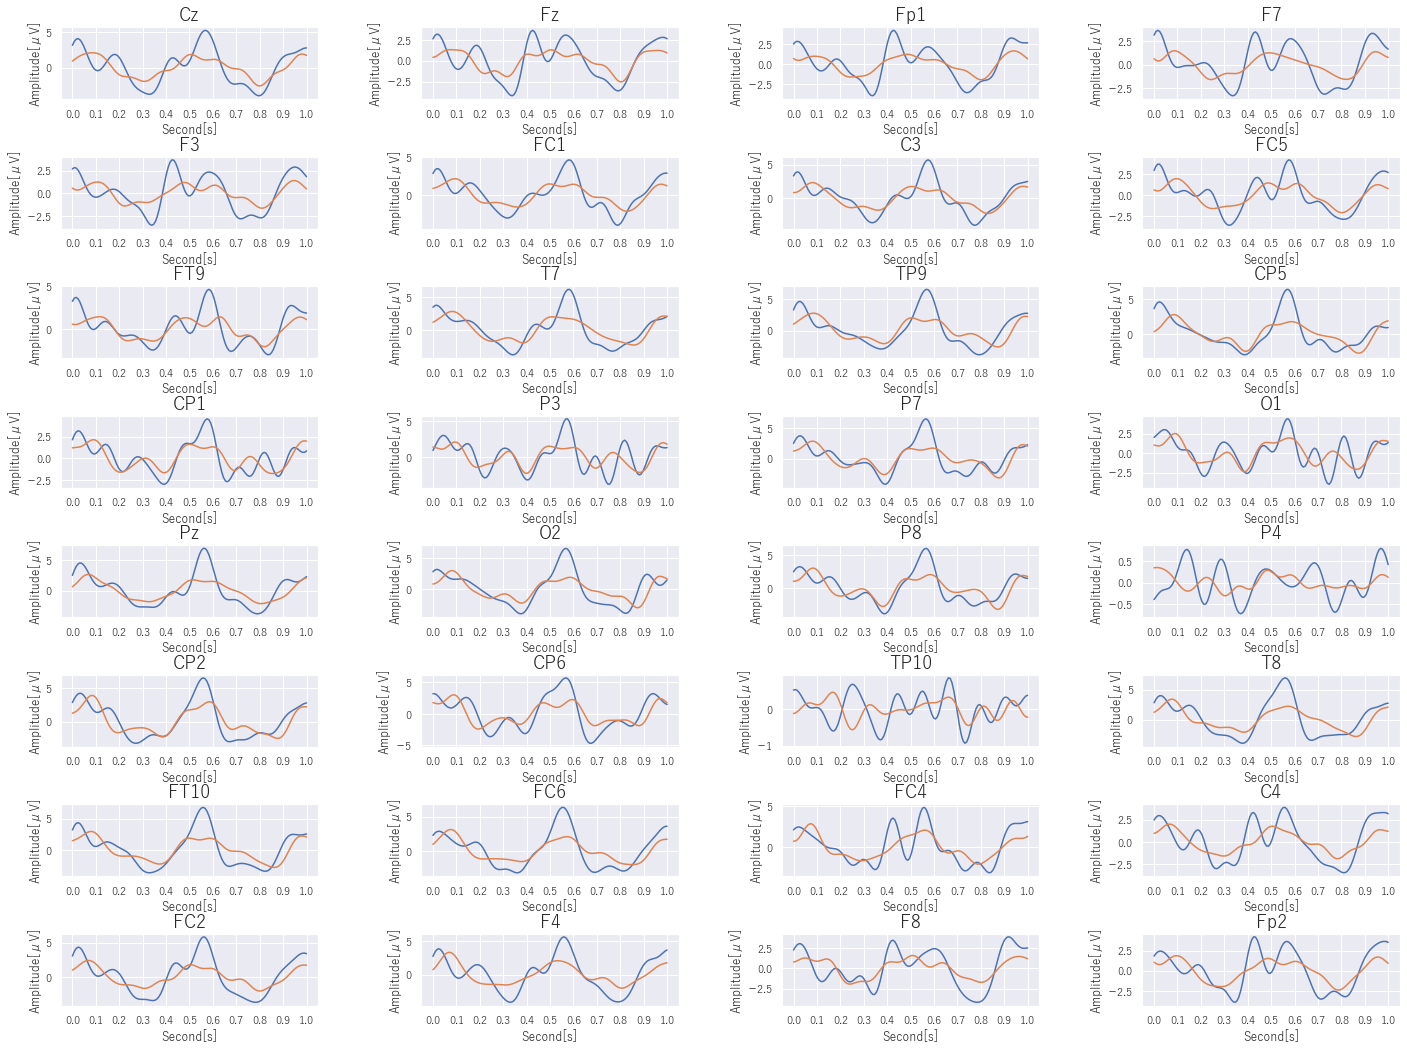

In [14]:
tt = np.linspace(0, 1, L39_target.shape[1])
channel = 15
plt.figure(figsize=(24, 18))
plt.subplots_adjust(wspace=0.4, hspace=0.8)
for i in range(len(channels)):
    plt.subplot(8, 4, i+1)
    plt.plot(tt, L39_target_ave[:, i], label="target")
    plt.plot(tt, L39_nontarget_ave[:, i], label="nontarget")
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Second[s]")
    plt.ylabel("Amplitude[μV]")
    plt.title(channels[i], fontsize=18)
#     plt.legend()

In [15]:
f, t, L39_target_spectrum = time_frequency_spectrum(L39_target)
L39_target_spectrum = (L39_target_spectrum - L39_target_spectrum.mean(axis=3, keepdims=True)) / L39_target_spectrum.std(axis=3, keepdims=True)
f, t, L39_nontarget_spectrum = time_frequency_spectrum(L39_nontarget)
L39_nontarget_spectrum = (L39_nontarget_spectrum - L39_nontarget_spectrum.mean(axis=3, keepdims=True)) / L39_nontarget_spectrum.std(axis=3, keepdims=True)

L39_target_spectrum.shape, L39_nontarget_spectrum.shape

((39, 49, 33, 5), (179, 49, 33, 5))

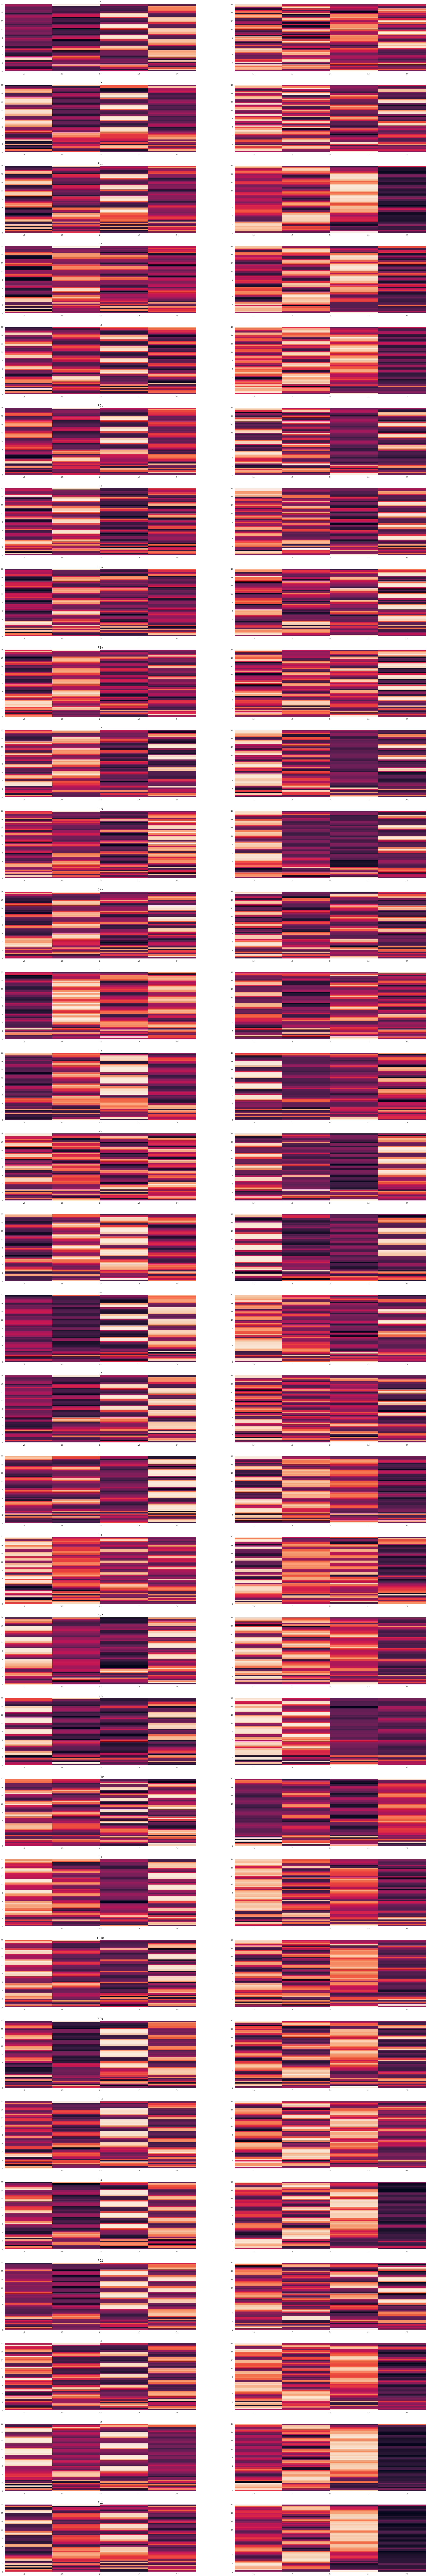

In [16]:
count = 0
plt.figure(figsize=(48, 300))
for i in range(len(channels)):
    plt.subplot(32, 2, count+1)
    plt.pcolormesh(t, f, L39_target_spectrum[9, :, i, :])
    plt.title(channels[i], fontsize=18)
    plt.subplot(32, 2, count+2)
    plt.pcolormesh(t, f, L39_nontarget_spectrum[6, :, i, :])
    count += 2